<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220728.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iteration

In [1]:
import pandas as pd 
import numpy as np
import plotnine as gg 
from plotnine import ggplot, aes 
from datetime import datetime, date, time, timezone, timedelta 
import os
import re 

from functools import reduce 
from collections import defaultdict, ChainMap, Counter

# customer analysis

In [2]:
os.listdir()

['.config',
 'items.csv',
 'retail_data_transactions.csv',
 'online_retail_II.xlsx',
 'shops.csv',
 'test.csv',
 'rfm_test.csv',
 'listings.csv',
 'ecommerce-data.csv',
 'sales_train.csv',
 'sample_submission.csv',
 '.Rhistory',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'item_categories.csv',
 'retail_data_response.csv',
 'sample_data']

In [3]:
df = pd.read_csv('retail_data_transactions.csv')
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [5]:
df['date'] = pd.to_datetime(df.trans_date)
df['month'] = df['date'].to_numpy().astype('datetime64[M]')
df = df[['customer_id','date','month','tran_amount']].rename(columns = {'customer_id':'id', 'tran_amount':'rev'})
df = df.groupby(['id','month','date'])['rev'].sum().reset_index()
df.head()

,id,month,date,rev
0,CS1112,2011-06-01,2011-06-15,56
1,CS1112,2011-08-01,2011-08-19,96
2,CS1112,2011-10-01,2011-10-02,60
3,CS1112,2012-04-01,2012-04-08,56
4,CS1112,2012-06-01,2012-06-24,52


In [6]:
list_pu = df.groupby(['id','month'])['rev'].sum().reset_index().sort_values(['id','month'], ascending = [1,0])
list_npu = df.groupby(['id']).first().reset_index()
list_mon = df['month'].sort_values().unique()

In [18]:
for mon in list_mon : 
  temp_npu = list_npu[list_npu['month'] == mon]
  temp_pu = list_pu[list_pu['id'].isin(temp_npu['id'])]
  temp = temp_pu.groupby(['month'])['id'].count().reset_index().rename(columns = {'id':'pu'})

  temp = temp.assign(nru_month = str(mon)[:10], 
                     num = temp['month'].rank(),
                     ratio = lambda x : round(x['pu']/x['pu'].max()*100,2)
                     )
  temp = temp[['nru_month', 'num', 'pu', 'ratio']]

  if mon == list_mon[0] :
    res = temp
  else : 
    res = pd.concat([res, temp], axis = 0)

res = pd.melt(res, id_vars = ['nru_month', 'num'], var_name = 'type', value_name = 'value')
res

,nru_month,num,type,value
0,2011-05-01,1.0,pu,1344.0
1,2011-05-01,2.0,pu,426.0
2,2011-05-01,3.0,pu,460.0
3,2011-05-01,4.0,pu,491.0
4,2011-05-01,5.0,pu,448.0
...,...,...,...,...
1539,2013-09-01,10.0,ratio,50.0
1540,2013-10-01,1.0,ratio,100.0
1541,2013-10-01,2.0,ratio,100.0
1542,2013-10-01,3.0,ratio,100.0


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


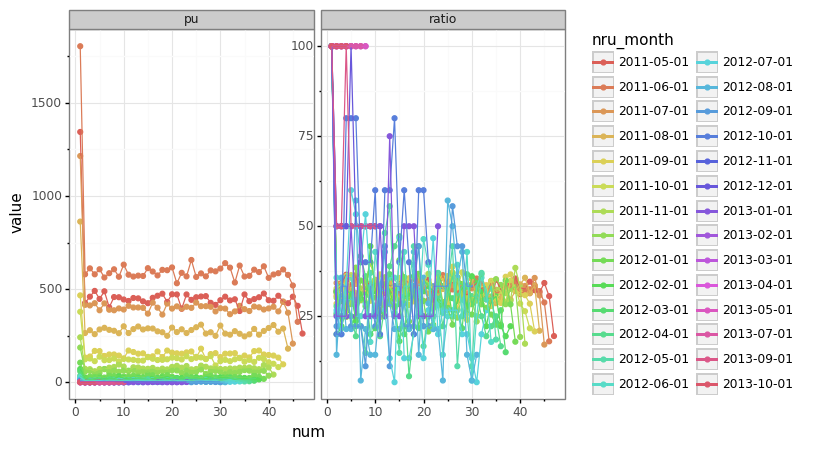

<ggplot: (8743882051173)>

In [15]:
(
    ggplot(res, aes('num', 'value', color = 'nru_month', group = 'nru_month')) +
    gg.geom_point() +
    gg.geom_line() +
    gg.facet_wrap('~type', scales = 'free_y') +
    gg.theme_bw()
)

In [20]:
info_m = df.groupby(['id', 'month'])['rev'].sum().reset_index().rename(columns = {'rev':'money'})
info_m = pd.pivot_table(info_m, index = 'id', columns = 'month', values = 'money').reset_index()
info_m = pd.melt(info_m, id_vars = 'id', var_name = 'month', value_name = 'money').sort_values(['id', 'month'], ascending = [1,0])
info_m = info_m.groupby(['id']).head(3)
info_m = info_m.groupby(['id'])['money'].sum().reset_index()
info_m.head()

,id,money
0,CS1112,39.0
1,CS1113,220.0
2,CS1114,79.0
3,CS1115,55.0
4,CS1116,0.0


In [21]:
info_f = df.groupby(['id', 'month'])['rev'].count().reset_index().rename(columns = {'rev':'freq'})
info_f = pd.pivot_table(info_f, index = 'id', columns = 'month', values = 'freq').reset_index()
info_f = pd.melt(info_f, id_vars = 'id', var_name = 'month', value_name = 'freq').sort_values(['id', 'month'], ascending = [1,0])
info_f = info_f.groupby(['id']).head(3)
info_f = info_f.groupby(['id'])['freq'].count().reset_index()
info_f.head()

,id,freq
0,CS1112,1
1,CS1113,2
2,CS1114,1
3,CS1115,1
4,CS1116,0


In [31]:
date_max = (df['date'] + pd.offsets.MonthEnd(0)).max()
date_max

Timestamp('2015-03-31 00:00:00')

In [32]:
info_r = df.groupby(['id']).agg({'date': lambda x : (date_max - x.max()).days}).reset_index().rename(columns = {'date':'recency'})
info_r.head()

,id,recency
0,CS1112,76
1,CS1113,50
2,CS1114,47
3,CS1115,26
4,CS1116,218


In [33]:
info = pd.merge(pd.merge(info_r, info_f, 'left', 'id'), info_m, 'left', 'id')
info.head()

,id,recency,freq,money
0,CS1112,76,1,39.0
1,CS1113,50,2,220.0
2,CS1114,47,1,79.0
3,CS1115,26,1,55.0
4,CS1116,218,0,0.0


In [34]:
info = info.assign(r = pd.qcut(info.recency, 5, list('54321')),
                   f = pd.qcut(info.freq.rank(method = 'first'), 5, list('12345')),
                   m = pd.qcut(info.money.rank(method = 'first'), 5, list('12345'))
                   )
info = info.assign(fm = info.r.astype(str) + info.m.astype(str))
info.head()

,id,recency,freq,money,r,f,m,fm
0,CS1112,76,1,39.0,3,2,3,33
1,CS1113,50,2,220.0,4,5,5,45
2,CS1114,47,1,79.0,4,2,4,44
3,CS1115,26,1,55.0,5,2,3,53
4,CS1116,218,0,0.0,1,1,1,11


# iteration

In [36]:
mat = [list('ABC'), list('DEF'), list('GHI')]
for r, rows in enumerate(mat) :
  for c, letter in enumerate(rows) : 
    print(f'({r},{c})-{letter}')

(0,0)-A
(0,1)-B
(0,2)-C
(1,0)-D
(1,1)-E
(1,2)-F
(2,0)-G
(2,1)-H
(2,2)-I


In [37]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'age': 73,
  'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M'},
 {'age': 29,
  'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F'},
 {'age': 51,
  'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M'},
 {'age': 32,
  'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F'},
 {'age': 42, 'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F'}]

In [38]:
for key in list(users[0].keys()) :
  if key == list(users[0].keys())[0] :
    res = eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])')
  else :
    res = np.c_[res, eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])')]

res

array([['gregorythomas@gmail.com', 'Brett Holland', 'M', '73'],
       ['hintoncynthia@hotmail.com', 'Madison Martinez', 'F', '29'],
       ['wwagner@gmail.com', 'Michael Jenkins', 'M', '51'],
       ['daniel79@gmail.com', 'Karen Rodriguez', 'F', '32'],
       ['ujackson@gmail.com', 'Amber Rhodes', 'F', '42']], dtype='<U25')

In [39]:
{key:eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])') for key in list(users[0].keys())}

{'age': [73, 29, 51, 32, 42],
 'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F']}

In [46]:
pd.DataFrame({key:eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])') for key in sorted(list(users[0].keys()))})

,age,mail,name,sex
0,73,gregorythomas@gmail.com,Brett Holland,M
1,29,hintoncynthia@hotmail.com,Madison Martinez,F
2,51,wwagner@gmail.com,Michael Jenkins,M
3,32,daniel79@gmail.com,Karen Rodriguez,F
4,42,ujackson@gmail.com,Amber Rhodes,F


In [47]:
portfolio = [
    ('GOOG', 100, 490.1),
    ('IBM', 50, 91.1),
    ('CAT', 150, 83.44),
    ('IBM', 100, 45.23),
    ('GOOG', 75, 572.45),
    ('AA', 50, 23.15)
]
portfolio

[('GOOG', 100, 490.1),
 ('IBM', 50, 91.1),
 ('CAT', 150, 83.44),
 ('IBM', 100, 45.23),
 ('GOOG', 75, 572.45),
 ('AA', 50, 23.15)]

In [49]:
a, b, c = Counter(), defaultdict(list), defaultdict(int)
for com, share, price in portfolio : 
  a[com] += 1
  b[com].append((share, price))
  c[com] += price

print(a)
print(b)
print(c)

Counter({'GOOG': 2, 'IBM': 2, 'CAT': 1, 'AA': 1})
defaultdict(<class 'list'>, {'GOOG': [(100, 490.1), (75, 572.45)], 'IBM': [(50, 91.1), (100, 45.23)], 'CAT': [(150, 83.44)], 'AA': [(50, 23.15)]})
defaultdict(<class 'int'>, {'GOOG': 1062.5500000000002, 'IBM': 136.32999999999998, 'CAT': 83.44, 'AA': 23.15})
